In [86]:
import math
import os
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
from keras import datasets, layers, models
from keras.layers import Dense, Dropout
import matplotlib.patches as patches
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import cv2
from keras.applications import VGG16
from keras.layers import Input, Flatten
from keras.models import Model
from keras.optimizers import Adam

In [87]:
# Global
root_path = os.path.join(os.getcwd(), 'login')

In [88]:
# Create Training and Validation Dataset

def xml_to_csv(root_path):
    annotations_path = os.path.join(root_path, 'Annotations')
    xml_list = []
    for xml_file in glob.glob(annotations_path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        if root.find('object'):
            for member in root.findall('object'):
                bbx = member.find('bndbox')                
                xmin = round(float(bbx.find('xmin').text))
                ymin = round(float(bbx.find('ymin').text))
                xmax = round(float(bbx.find('xmax').text))
                ymax = round(float(bbx.find('ymax').text))
                label = member.find('name').text
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        label,
                        xmin,
                        ymin,
                        xmax,
                        ymax
                        )
                xml_list.append(value)

    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
    
def generate():
    # Remove old
    ds_path = os.path.join(root_path, 'Data', f"all_data.csv")
    if os.path.exists(ds_path):
        os.remove(ds_path)

    xml_df = xml_to_csv(root_path)
    xml_df.to_csv(ds_path, index=None)

    print('Successfully converted xml to csv.')

generate()

Successfully converted xml to csv.


In [89]:
adjust_factor = 5
im_width = int(2560/adjust_factor)
im_height = int(1850/adjust_factor)
classes = ['Login']
data = []
labels = []
bboxes = []
imagePaths = []

In [90]:
def create_sets():
    ds_path = os.path.join(root_path, 'Data', f"all_data.csv")
    image_root = os.path.join(root_path, 'images')
    image_records = pd.read_csv(ds_path)

    for index, row in image_records.iterrows():
        
        (filename, width, height, class_name, Xmin, Ymin, Xmax, Ymax) = row

        image_path = os.path.join(image_root, filename)
        train_img = load_img(image_path, target_size=(im_height, im_width))
        image = img_to_array(train_img)

        Xmin = round(float(Xmin/adjust_factor) / im_width, 2)
        Ymin = round(float(Ymin/adjust_factor) / im_height, 2)
        Xmax = round(float(Xmax/adjust_factor) / im_width, 2)
        Ymax = round(float(Ymax/adjust_factor) / im_height, 2)

        data.append(image)
        labels.append(class_name)
        imagePaths.append(image_path)
        bboxes.append((Xmin, Ymin, Xmax, Ymax)) 
    

create_sets()

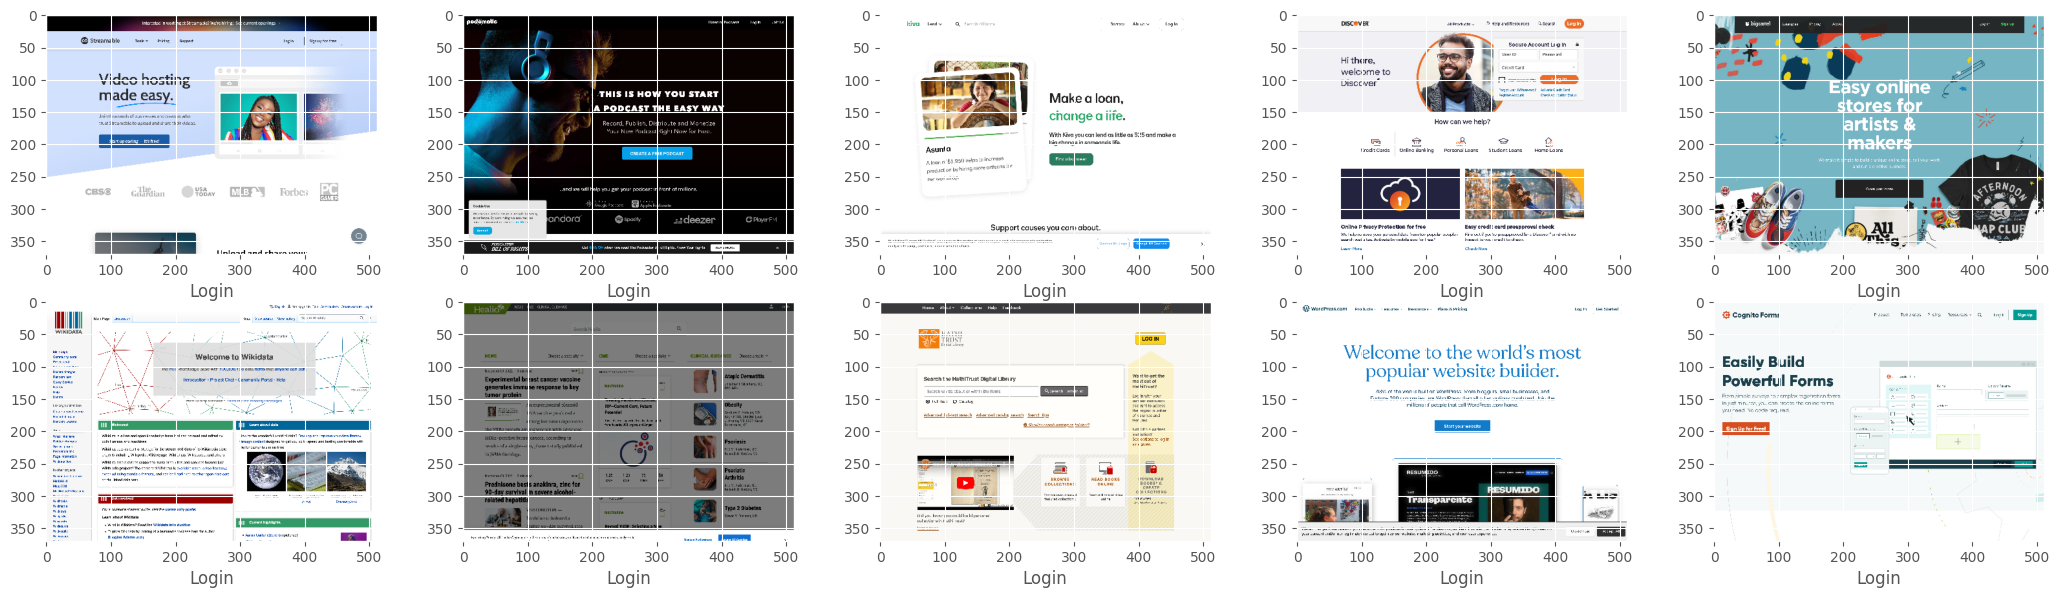

In [91]:
#Show
def show():
    plt.figure(figsize=(26,18))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xlabel('Login')
        plt.imshow(array_to_img(data[i]))
        
show()

(0.8, 0.02, 0.84, 0.05)


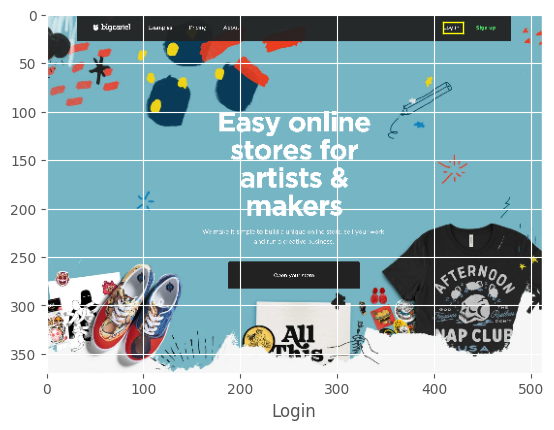

In [92]:
# Show Image with Bounding Box
idx = 4
box = bboxes[idx]
im_data = data[idx]

print(box)

x1 = box[0] * im_width 
y1 = box[1] * im_height 
x2 = box[2] * im_width
y2 = box[3] * im_height 

linewidth = 1
color = "yellow"
label = 'Login'

plt.xlabel('Login')

plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color)
plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color)
plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color)
plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color)
plt.imshow(array_to_img(data[idx]))

plt.show()


In [93]:
# convert from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0

print(data.shape)

#convert to numpy array
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

(173, 370, 512, 3)


In [94]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [95]:
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)

In [96]:
split = train_test_split(data,
                         labels,
                         bboxes,
                         imagePaths,
                         test_size=0.20,
                         random_state=42)

In [97]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [98]:
print(trainImages.shape)

(138, 370, 512, 3)


In [99]:
# vgg = VGG16(weights="imagenet",
#             include_top=False,
#             input_tensor=Input(shape=(im_height, im_width, 3)))
# vgg.trainable = False

In [100]:
# flatten = vgg.output
# flatten = Flatten()(flatten)

In [101]:
input_shape = (im_height, im_width, 3)
input_layer = Input(input_shape)

flatten = layers.Rescaling(1./255, name='bl_1')(input_layer)
flatten = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(flatten)
flatten = layers.MaxPooling2D(name='bl_3')(flatten)
flatten = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(flatten)
flatten = layers.MaxPooling2D(name='bl_5')(flatten)
flatten = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(flatten)
flatten = layers.MaxPooling2D(name='bl_7')(flatten)
flatten = layers.Flatten(name='bl_8')(flatten)

In [102]:
# construct a fully-connected layer 
# header to output the predicted
# bounding box coordinates

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

In [103]:
# construct a second fully-connected 
# layer header to predict
# the class label

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [104]:
model = Model(inputs=input_layer, outputs=(bboxHead, softmaxHead))
# model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

In [105]:
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 64

In [106]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

In [107]:
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [108]:
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [109]:
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

In [110]:
opt = Adam(INIT_LR)

model.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"], 
              loss_weights=lossWeights)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 370, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 370, 512, 3)  0           ['input_3[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 370, 512, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                            

In [111]:
history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

Epoch 1/20
3/3 [==============================] - 13s 3s/step - loss: 0.1616 - bounding_box_loss: 0.1616 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.0000e+00 - val_loss: 0.1643 - val_bounding_box_loss: 0.1643 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.0000e+00 - val_class_label_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 10s 3s/step - loss: 0.1579 - bounding_box_loss: 0.1579 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.0000e+00 - val_loss: 0.1560 - val_bounding_box_loss: 0.1560 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.0000e+00 - val_class_label_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 9s 3s/step - loss: 0.1485 - bounding_box_loss: 0.1485 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.0000e+00 - val_loss: 0.1400 - val_bounding_box_loss: 0.1400

<AxesSubplot:>

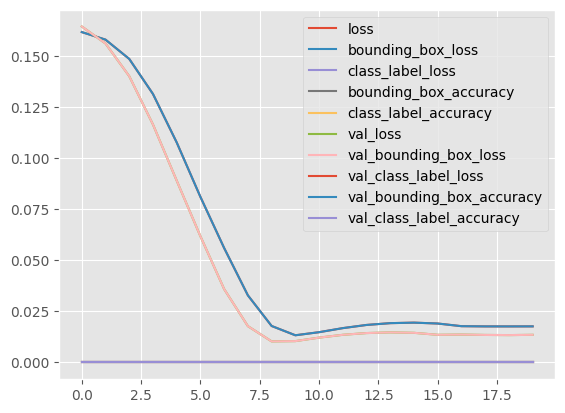

In [112]:
# Plotting train vs validation
import pandas as pd
pd.DataFrame(history.history).plot()

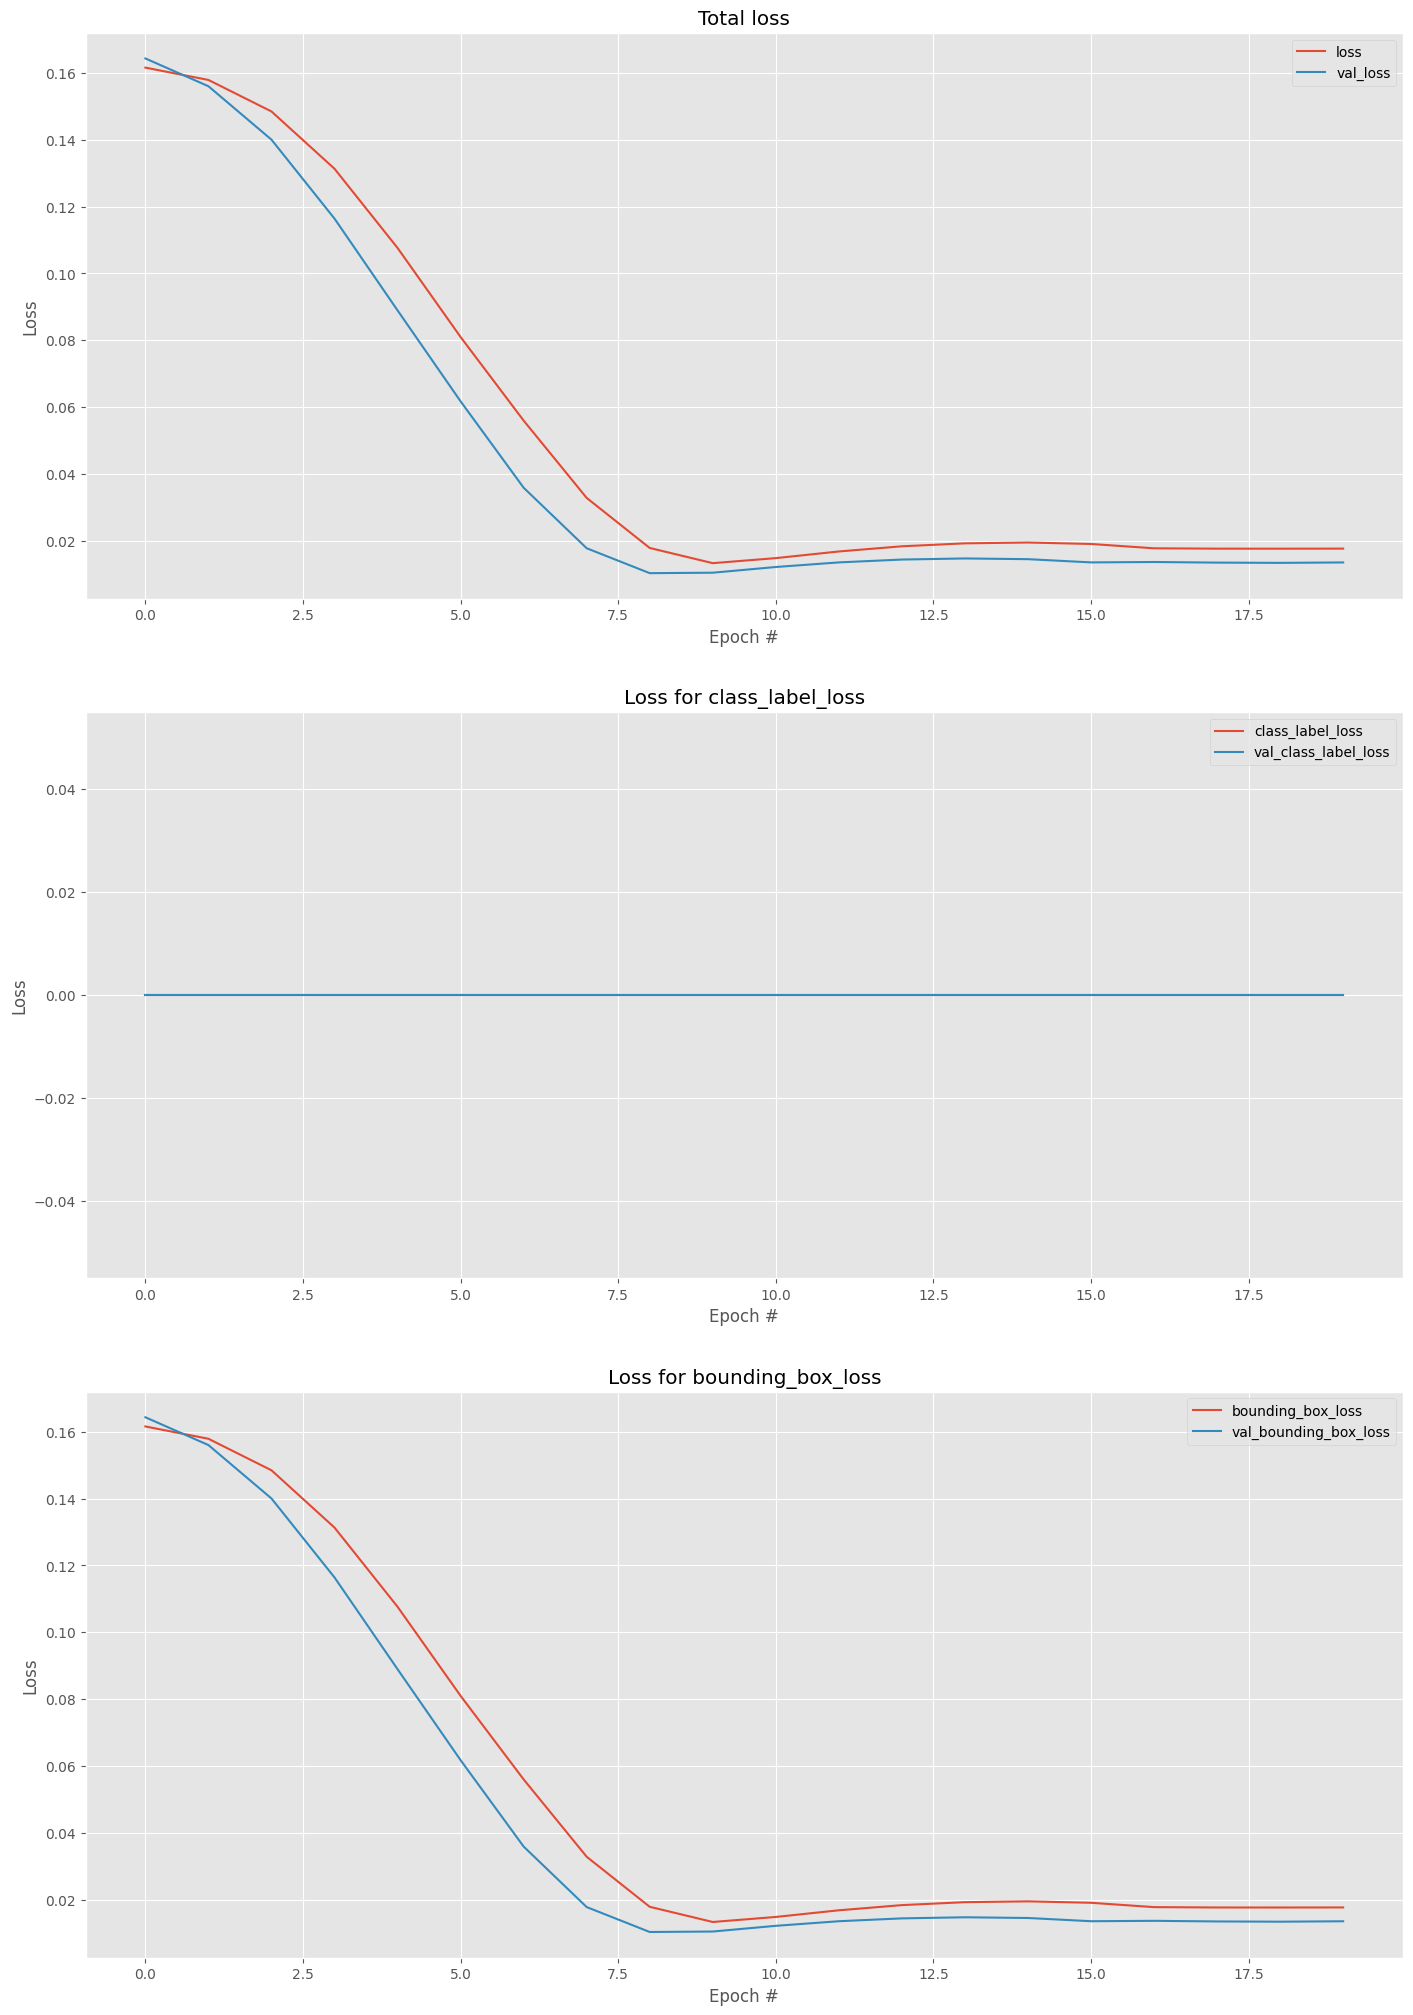

In [113]:
lossNames = ["loss", 
             "class_label_loss", 
             "bounding_box_loss"]

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(17, 25))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, history.history[l], label=l)
    ax[i].plot(N, history.history["val_" + l], label="val_" + l)
    ax[i].legend()

1/1 [==============================] - 0s 430ms/step


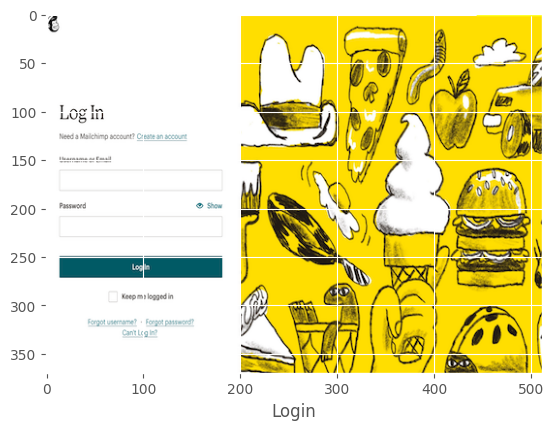

In [122]:

filename = 'mailchimp.png'
imagePath = os.path.join(root_path, 'test_images', filename)
image = load_img(imagePath, target_size=(im_height, im_width))
image = img_to_array(image) / 255.0
image_p = np.expand_dims(image, axis=0)

(boxPreds, labelPreds) = model.predict(image_p)
(startX, startY, endX, endY) = boxPreds[0]

x1 = startX * im_width 
y1 = startY * im_height 
x2 = endX * im_width
y2 = endY * im_height 

linewidth = 1
color = "yellow"
label = 'Login'

plt.xlabel('Login')

plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color)
plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color)
plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color)
plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color)
plt.imshow(array_to_img(image))
